# sen_map notebook

In [1]:
from __future__ import absolute_import, division, print_function 
import os
import re
import sys
import time

sys.path.append(os.path.join('.', '..')) 
import utils
import utils_DL
import utils_s160159 as u_s

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


## Load data

In [2]:
data_dir = './../Data'
logs_path = './logs'
BATCH_SIZE = 1 # 75
NUM_SUBJECTS = 20
NUM_CLASSES = 6
#VAL_PER = 0.05
#VAL_TRAIN_ID = NUM_SUBJECTS - int(NUM_SUBJECTS * VAL_PER) - 1
VAL_TRAIN_ID = NUM_SUBJECTS - 4

In [3]:
#Load all subjects into memory
subjects_list = []
for i in range(VAL_TRAIN_ID+1, NUM_SUBJECTS+1):
    print("Loading subject %d..." %(i))
    inputs_night1, targets_night1, _  = u_s.load_spectrograms(data_path=data_dir, 
                                                              subject_id=i, 
                                                              night_id=1)
    if i!=20:
        inputs_night2, targets_night2, _  = u_s.load_spectrograms(data_path=data_dir, 
                                                                  subject_id=i, 
                                                                  night_id=2)
    else:
        inputs_night2 = np.empty((0,224,224,3),dtype='uint8')
        targets_night2 = np.empty((0,NUM_CLASSES),dtype='uint8')           

    current_inputs = np.concatenate((inputs_night1,inputs_night2),axis=0)
    current_targets = np.concatenate((targets_night1, targets_night2),axis=0)
    
    subjects_list.append([current_inputs, current_targets])
        
# extract image shapes
IMAGE_SHAPE = subjects_list[0][0].shape

Loading subject 17...
Loading subject 18...
Loading subject 19...
Loading subject 20...


## Restoring the model and  create per class sensitivity map

INFO:tensorflow:Restoring parameters from ./models/master/Version_0.0_Mon Nov 13 23:43:41 2017/fold_1/model
Creating sen_map of: 1 of 6


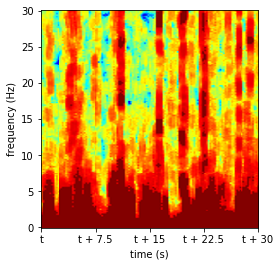

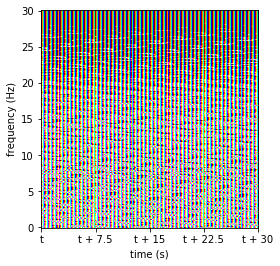

In [8]:
tf.reset_default_graph()
model_path = './models/master/Version_0.0_Mon Nov 13 23:43:41 2017/fold_1/model'

with tf.Session() as sess:
    try:
        # restore model
        my_load = tf.train.import_meta_graph(model_path + '.meta', clear_devices=True)
        my_load.restore(sess, model_path)
        grad_output_wrt_input = tf.get_collection('grad_output_wrt_input')[0]
        weights_pl = tf.get_collection('weights_pl')[0]
        x_pl = tf.get_collection('x_pl')[0]
        y_pl = tf.get_collection('y_pl')[0]
        

        #
        for cur_class in range(NUM_CLASSES):
            print('Creating sen_map of: ' + str(cur_class + 1) + ' of ' + str(NUM_CLASSES))
            # Extract data
            _data = [subjects_list[i] for i in range(len(subjects_list)) if np.argmax(subjects_list[i][1]) == cur_class]

            inputs_data = np.empty((0,IMAGE_SHAPE[1],IMAGE_SHAPE[2],IMAGE_SHAPE[3]),dtype='uint8')  
            targets_data = np.empty((0,NUM_CLASSES),dtype='uint8') 

            grad_accum = np.empty((0,IMAGE_SHAPE[1],IMAGE_SHAPE[2],IMAGE_SHAPE[3]))
            x_batch_accum = np.empty((0,IMAGE_SHAPE[1],IMAGE_SHAPE[2],IMAGE_SHAPE[3]))

            # loop data for current class
            for item in _data:
                inputs_data = np.concatenate((inputs_data, item[0]),axis=0)
                targets_data = np.concatenate((targets_data, item[1]),axis=0)
                # end loop

            # loop mini bacthes
            _iter = 0
            for x_batch, y_batch in utils.iterate_minibatches(batchsize=BATCH_SIZE, 
                                                              inputs=inputs_data, 
                                                              targets=targets_data, 
                                                              shuffle=False):
                _iter += 1
                
                
                # convert from uint8 to float32
                #x_batch = np.float32(x_batch)/255.0

                # feed trained network
                _grads = sess.run(fetches=grad_output_wrt_input, 
                                  feed_dict={x_pl: x_batch,
                                             y_pl: y_batch,
                                             weights_pl: np.ones_like(y_batch)})
                

                grad_accum = np.concatenate((grad_accum, _grads), axis=0) 
                x_batch_accum = np.concatenate((x_batch_accum, x_batch), axis=0) 
                # end loop
                break

            # Calcualte Sensitivity maps  
            u_s.cal_sen_map(x_batch_accum, sen_map_class='raw_' + str(cur_class), 
                            save_dir = './pics/', IMAGE_SHAPE=IMAGE_SHAPE)
            u_s.cal_sen_map(grad_accum, sen_map_class='loss_' + str(cur_class),
                            save_dir = './pics/', IMAGE_SHAPE=IMAGE_SHAPE)
            break
        # close session
        sess.close()

    except KeyboardInterrupt:
        pass